# **Data Cleaning**

## Objectives

* Clean the data by handling missing values and ensuring correct data types.
* Standardize numerical features to improve consistency and model training.
* Save the cleaned dataset for further analysis and modeling.

## Inputs

* outputs/datasets/collection/HousePricesRecords.csv`: The raw collected data from the Data Collection step

## Outputs

* outputs/datasets/cleaned/HousePricesCleaned.csv`: The cleaned data, ready for feature engineering and analysis

---

# Change working directory

* The notebooks are stored in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [13]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [14]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [15]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

## Load data

**Load the data** from the generated CSV file to inspect data types and preview the dataset structure.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.imputation import CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.selection import DropFeatures
from sklearn.pipeline import Pipeline

df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")
df.head


<bound method NDFrame.head of       1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0        856.0     854.0           3.0           No       706.0          GLQ   
1       1262.0       0.0           3.0           Gd       978.0          ALQ   
2        920.0     866.0           3.0           Mn       486.0          GLQ   
3        961.0       NaN           NaN           No       216.0          ALQ   
4       1145.0       NaN           4.0           Av       655.0          GLQ   
...        ...       ...           ...          ...         ...          ...   
1455     953.0     694.0           3.0           No         0.0          Unf   
1456    2073.0       0.0           NaN           No       790.0          ALQ   
1457    1188.0    1152.0           4.0           No       275.0          GLQ   
1458    1078.0       0.0           2.0           Mn        49.0          NaN   
1459    1256.0       0.0           3.0           No       830.0          BLQ   

      Bsm

**Visualize missing values** to easily identify which columns have missing data

In [2]:
# Evaluate the proportion of missing values per column
def evaluate_missing_data(df):
    missing_data = df.isnull().sum()
    percentage_missing = (missing_data / len(df)) * 100
    missing_summary = pd.DataFrame({
        "MissingValues": missing_data,
        "PercentageMissing": percentage_missing
    })
    print("\nMissing values per column:")
    print(missing_summary[missing_summary["MissingValues"] > 0])

# Call the function to evaluate missing values
evaluate_missing_data(df)


Missing values per column:
               MissingValues  PercentageMissing
2ndFlrSF                  86           5.890411
BedroomAbvGr              99           6.780822
BsmtExposure              38           2.602740
BsmtFinType1             145           9.931507
EnclosedPorch           1324          90.684932
GarageFinish             235          16.095890
GarageYrBlt               81           5.547945
LotFrontage              259          17.739726
MasVnrArea                 8           0.547945
WoodDeckSF              1305          89.383562


**Visualize** which columns have missing data and how much is missing, making it easier to decide on handling strategies.

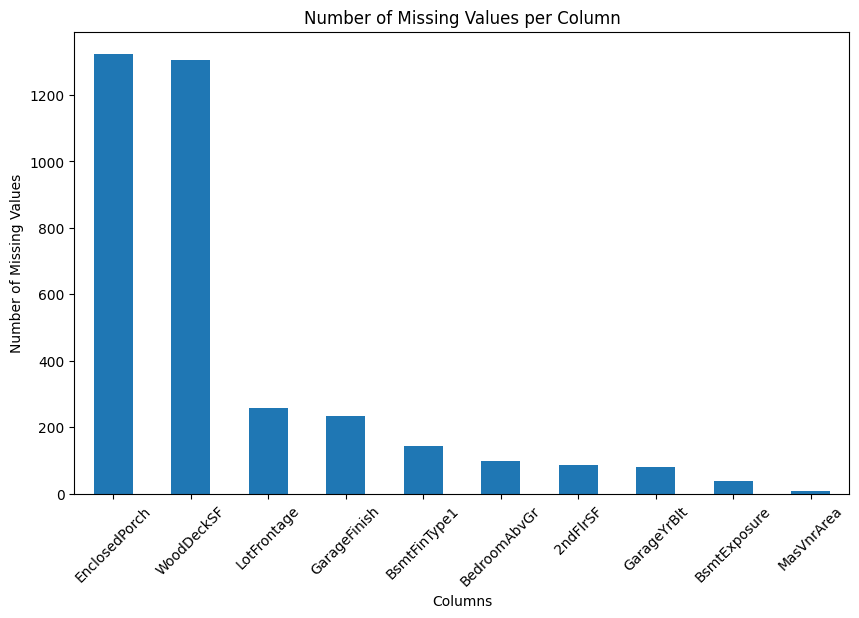

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary of missing values sorted in descending order
missing_data_summary = df.isnull().sum().sort_values(ascending=False)
missing_data_summary = missing_data_summary[missing_data_summary > 0]  # Include only columns with missing values

# Bar plot showing the number of missing values per column
plt.figure(figsize=(10, 6))
missing_data_summary.plot(kind='bar')
plt.title('Number of Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()


**Columns like 'EnclosedPorch' and 'WoodDeckSF' have over 89% missing values and will be removed because they do not directly impact the model or business goal.**

In [ ]:
# List of features to drop
dropped_features = ['EnclosedPorch', 'WoodDeckSF']

# List of categorical features
categorical_features = ['GarageFinish', 'BsmtFinType1', 'BsmtExposure']
median_features = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']
features_to_impute_with_zero = ['2ndFlrSF', 'MasVnrArea']

# Create a pipeline to clean the data
pipeline = Pipeline([
    # Dropping irrelevant or highly missing features
    ('DropFeatures', DropFeatures(features_to_drop=dropped_features)),
    ('CategoricalImputer', CategoricalImputer(imputation_method='frequent', variables=categorical_features)),
    ('MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=median_features)),
    ('ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0, variables=features_to_impute_with_zero)),
])

# Apply the pipeline to the dataframe to clean the data
df_cleaned = pipeline.fit_transform(df)


print("Missing values after cleaning:")
print(df_cleaned.isnull().sum())


Missing values after cleaning:
1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64


**Remove duplicates**

Remove duplicates to keep data clean and avoid repeated information that could harm model accuracy.

In [5]:
df.drop_duplicates(inplace=True)
print(f"Duplicates after cleaning: {df.duplicated().sum()}")
print(f"Shape of data after removing duplicates: {df.shape}")

Duplicates after cleaning: 0
Shape of data after removing duplicates: (1460, 24)


___

Outliers are removed from important features by using the 2nd and 98th percentiles as limits. This helps reduce the effect of extreme values and makes the model perform better.

In [ ]:
# Define important features for outlier handling
important_features = ['LotArea', 'GrLivArea', 'SalePrice']

# Calculate limits for each important feature based on percentiles
lower_percentile = 0.02
upper_percentile = 0.98

# Filter out outliers based on the threshold values
for feature in important_features:
    lower_limit = df_cleaned[feature].quantile(lower_percentile)
    upper_limit = df_cleaned[feature].quantile(upper_percentile)
    
    df_cleaned = df_cleaned[(df_cleaned[feature] >= lower_limit) & (df_cleaned[feature] <= upper_limit)]

print(f"Shape of data after removing outliers: {df_cleaned.shape}")


Shape of data after removing outliers: (1290, 22)


**Log or Box-Cox** transformations reduce skewness in data to make it more even. Scaling numerical features helps the model learn better from them. StandardScaler was used to standardize numerical features so they are on the same scale, which speeds up model training and enhances accuracy.

In [ ]:
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

# Features that need to be transformed due to skewness
features_to_transform = ['LotArea', 'MasVnrArea', '2ndFlrSF']

# log transformation or Box-Cox to reduce skewness
for feature in features_to_transform:
    if feature == 'LotArea':
        df_cleaned[feature] = np.log1p(df_cleaned[feature])
    else:
        if (df_cleaned[feature] > 0).all():
            df_cleaned[feature], _ = boxcox(df_cleaned[feature])

# Select the numerical features for scaling
numerical_features = df_cleaned.select_dtypes(include=['number']).columns

# StandardScaler and scale the data
scaler = StandardScaler()
df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])

print("Data is now cleaned, transformed, and ready for modeling.")


Data is now cleaned, transformed, and ready for modeling.


**Visualize outliers** to identify potential data issues
helps decide if handling outliers is needed later


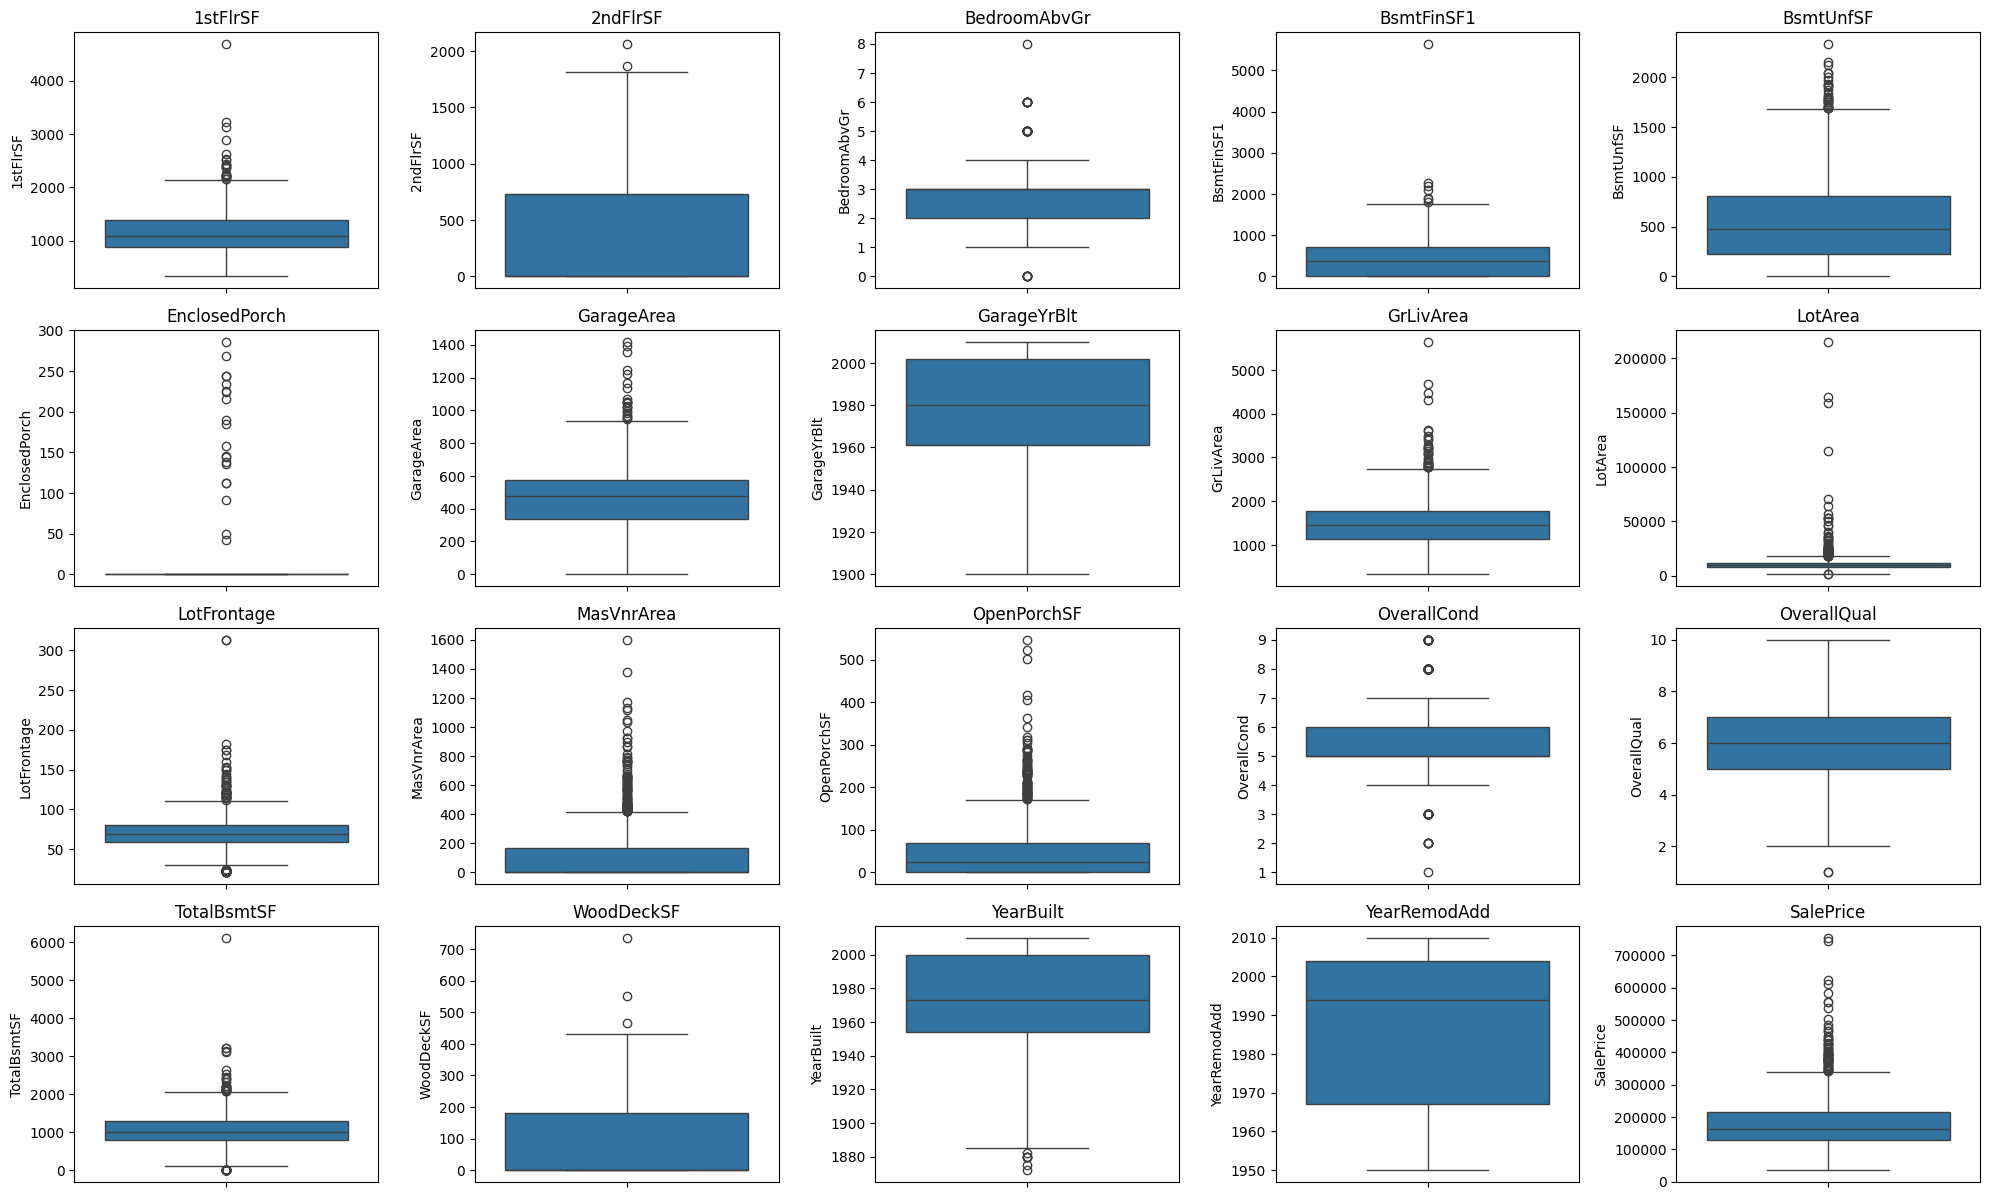

In [8]:
# Visualize outliers with boxplot for numerical features
numerical_features = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(y=df[feature])
    plt.title(f'{feature}')

plt.tight_layout()
plt.show()


There were extreme outliers initially, which could have negatively impacted the model's performance. After transformations like log and Box-Cox, the outliers were still present but reduced. These transformations will help the model learn better and perform more accurately. Reducing skewness and minimizing the impact of extreme values made the data more suitable for training.

___

**Convert object to category**

The code converts specific columns to the 'category' data type to save memory and speed up processing.

In [9]:
df_cleaned['BsmtExposure'] = df_cleaned['BsmtExposure'].astype('category')
df_cleaned['BsmtFinType1'] = df_cleaned['BsmtFinType1'].astype('category')
df_cleaned['GarageFinish'] = df_cleaned['GarageFinish'].astype('category')
df_cleaned['KitchenQual'] = df_cleaned['KitchenQual'].astype('category')

**matplotlib was used to create histograms of the dataset**

Histograms are used to visualize the data after cleaning. This helps to verify if the cleaning steps were effective and identify any remaining patterns or issues in the data.

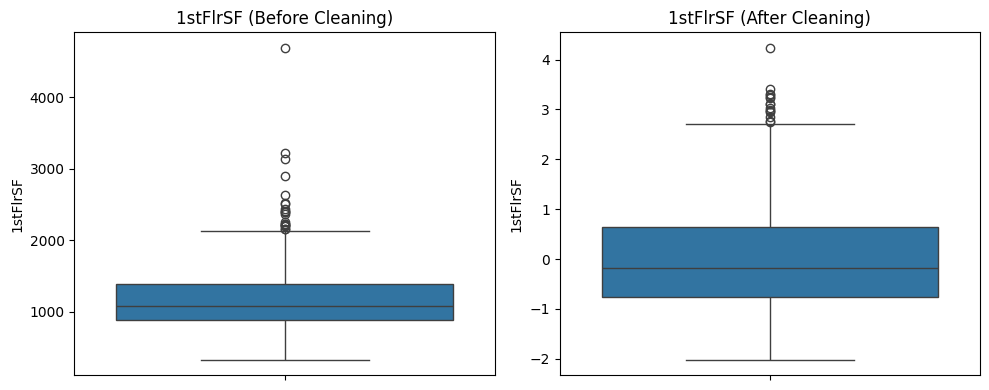

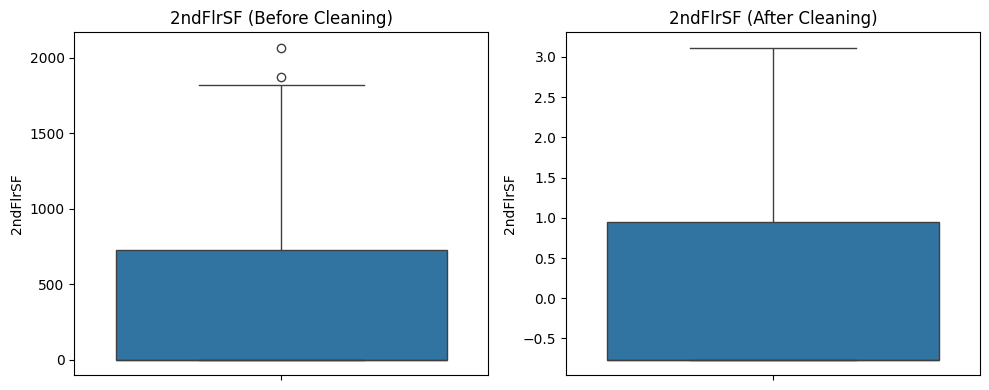

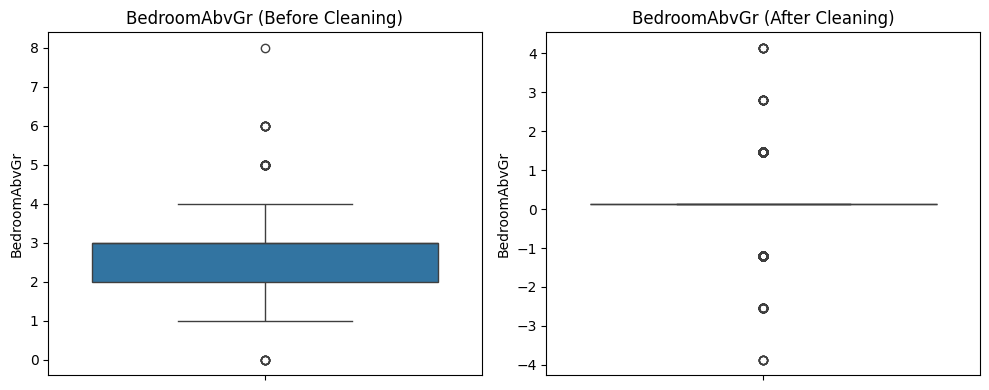

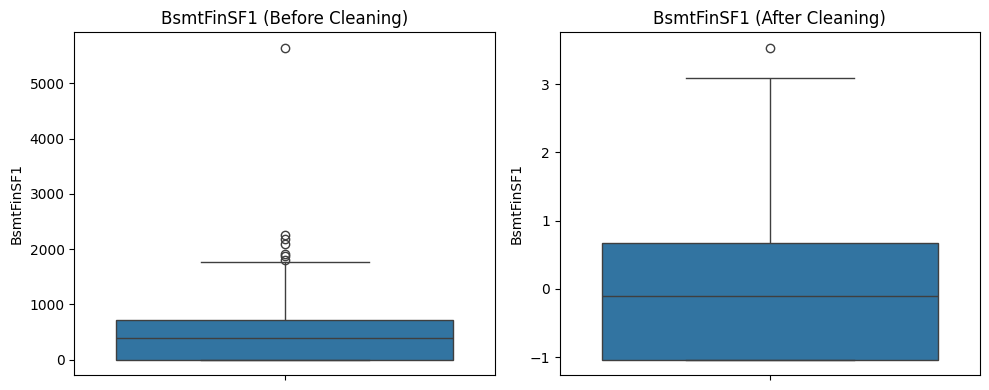

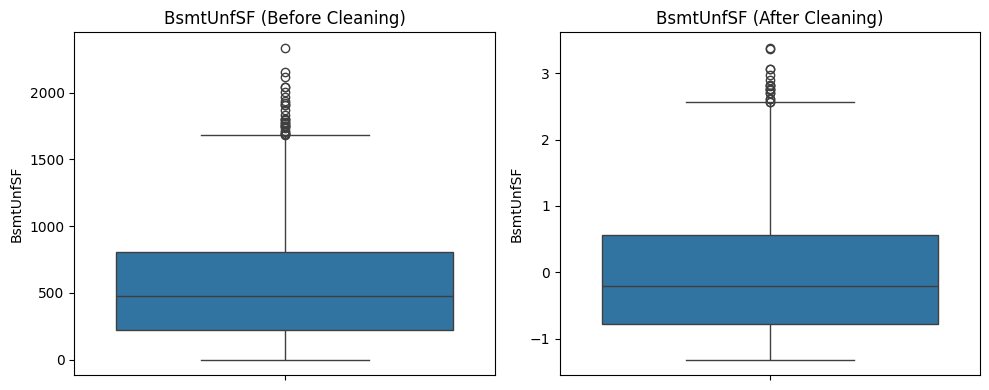

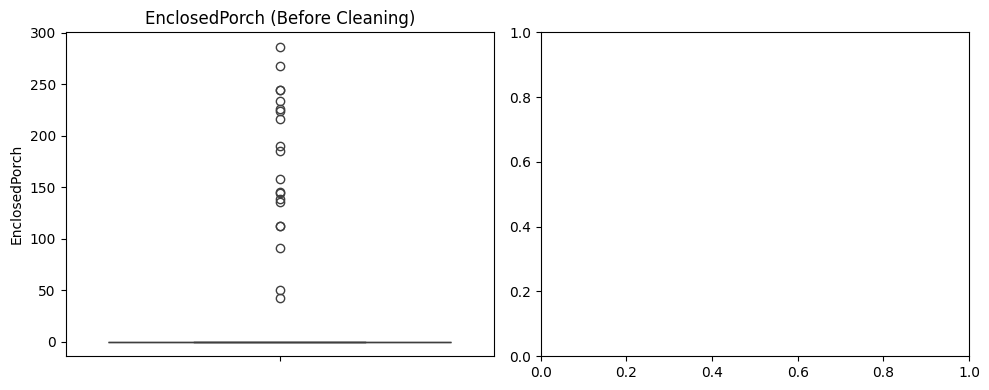

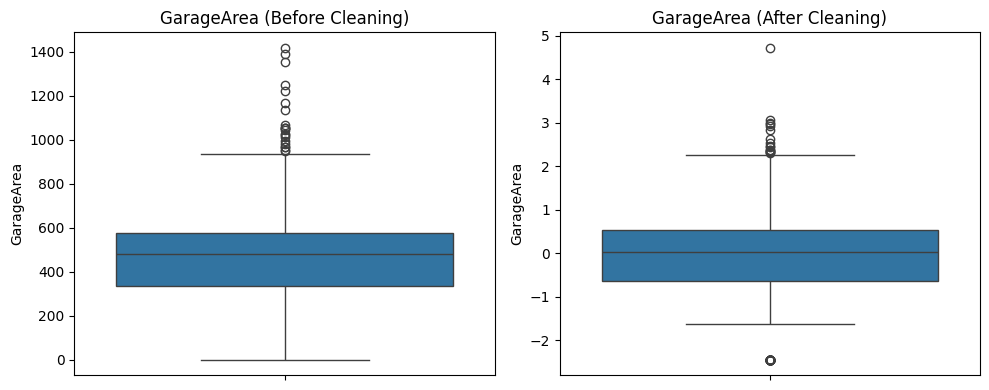

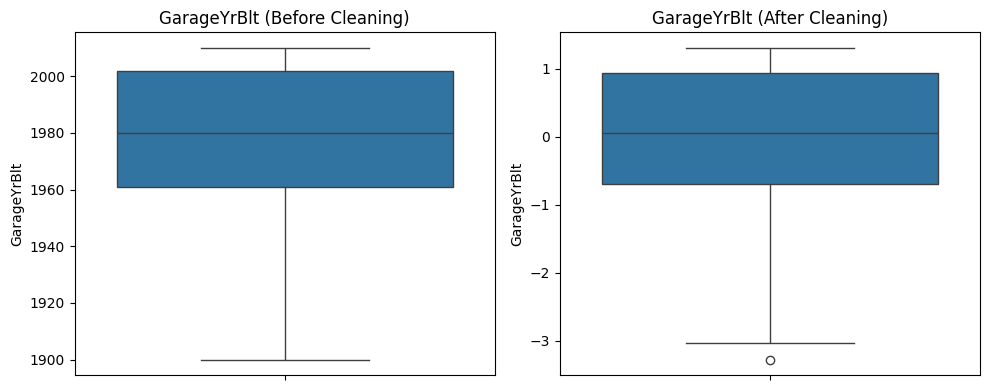

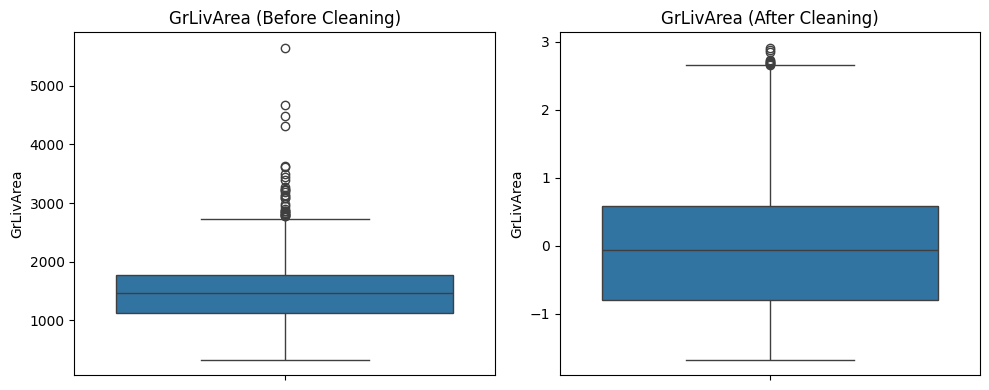

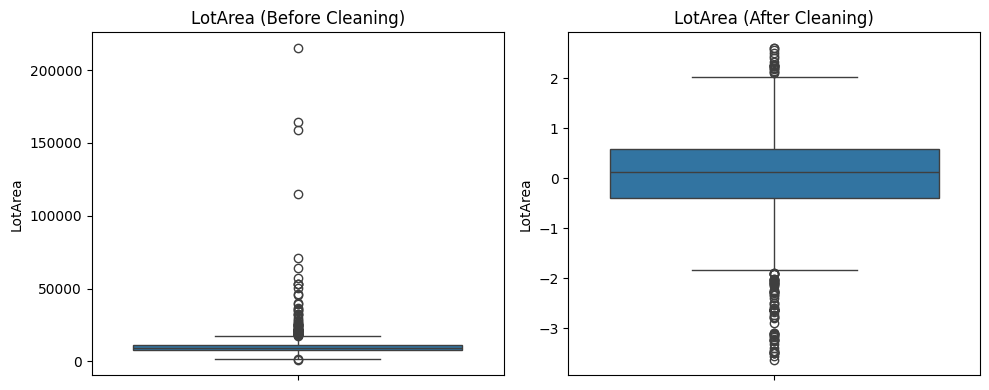

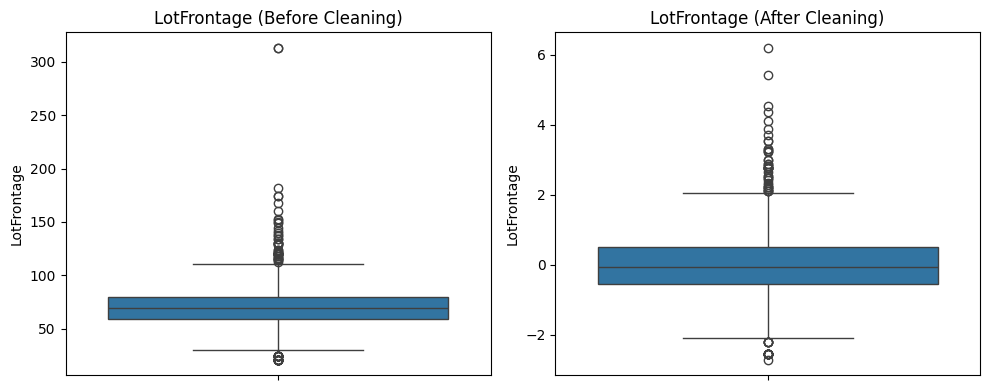

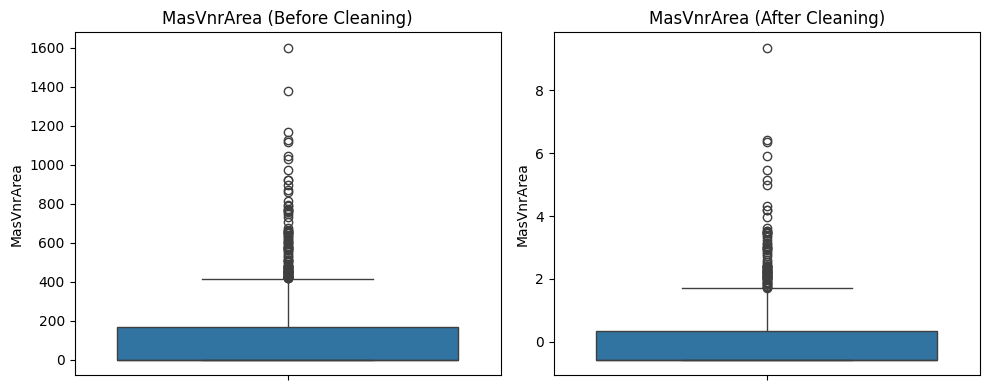

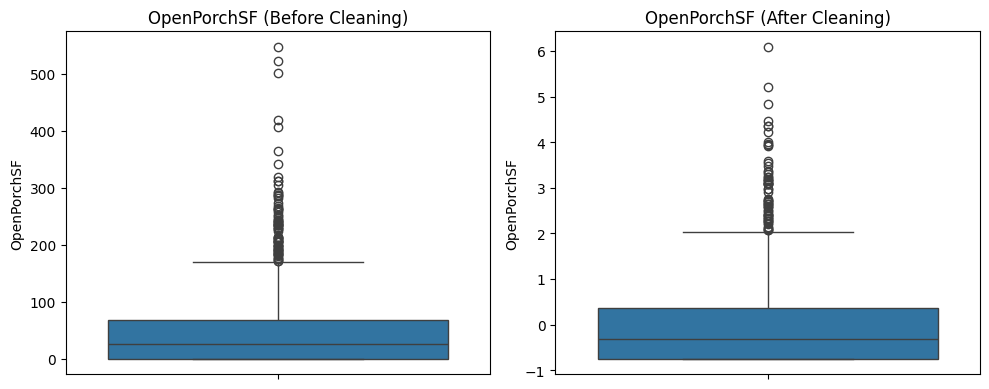

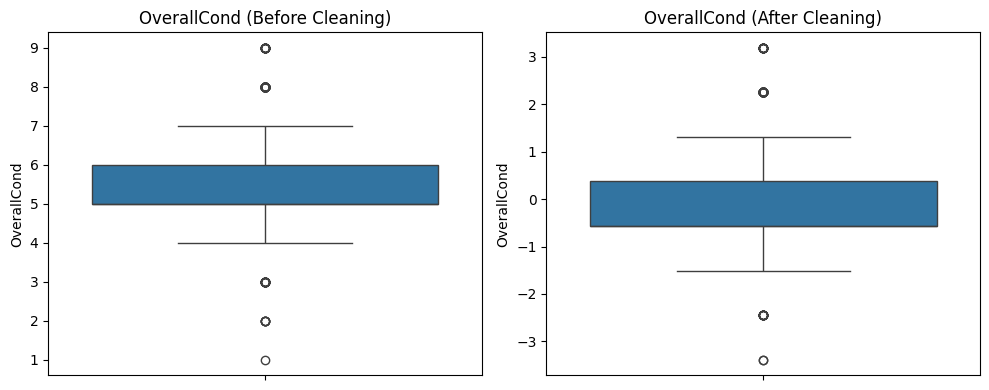

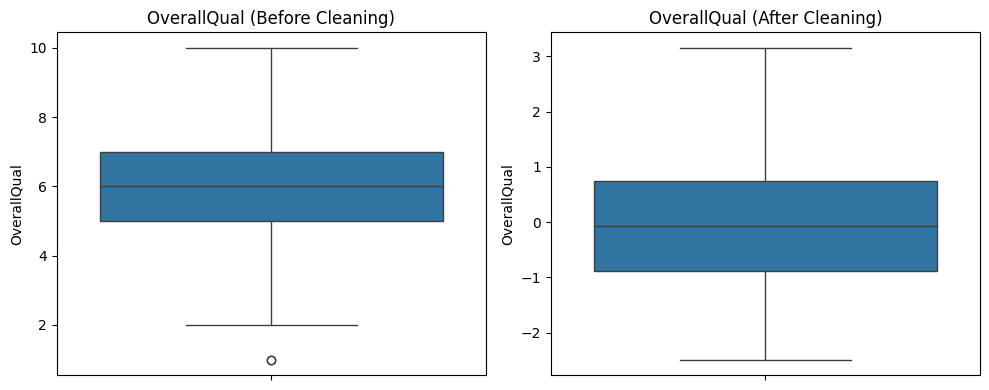

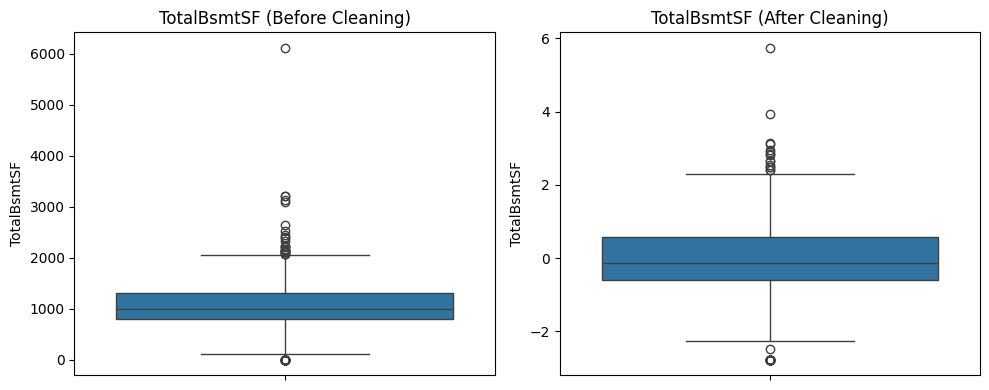

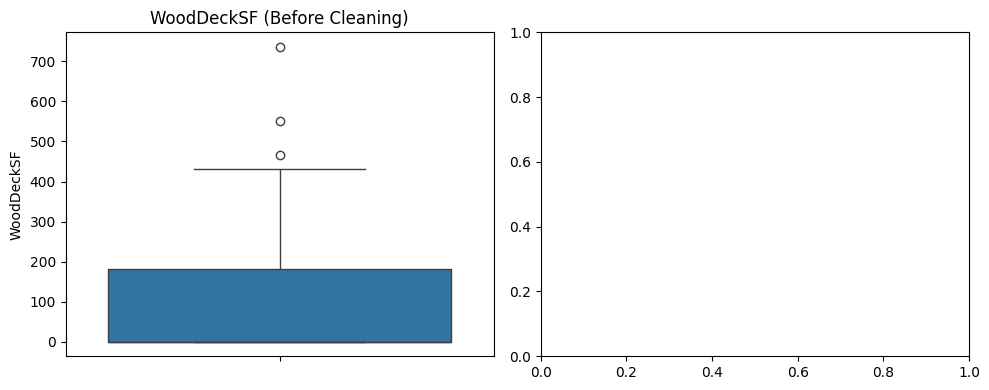

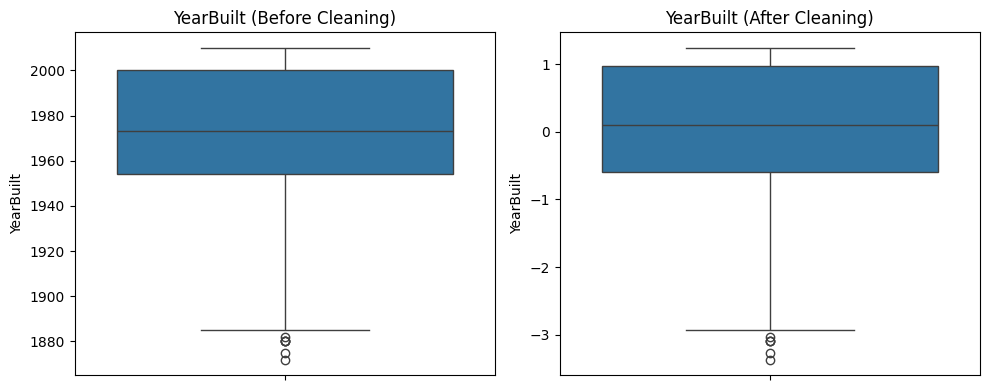

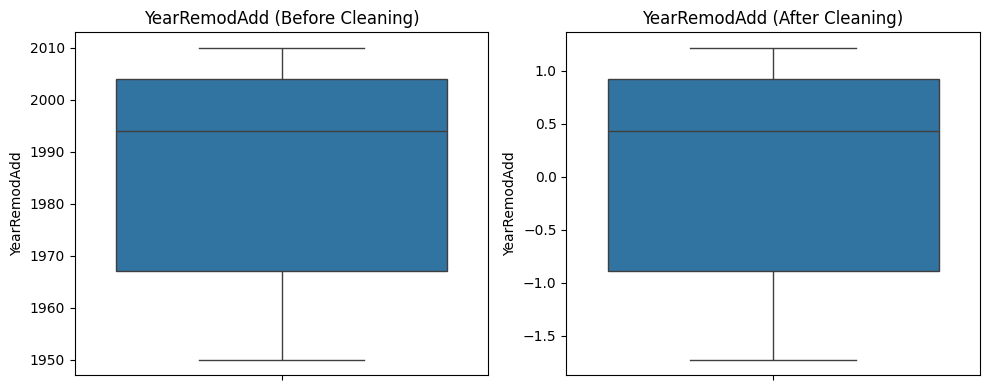

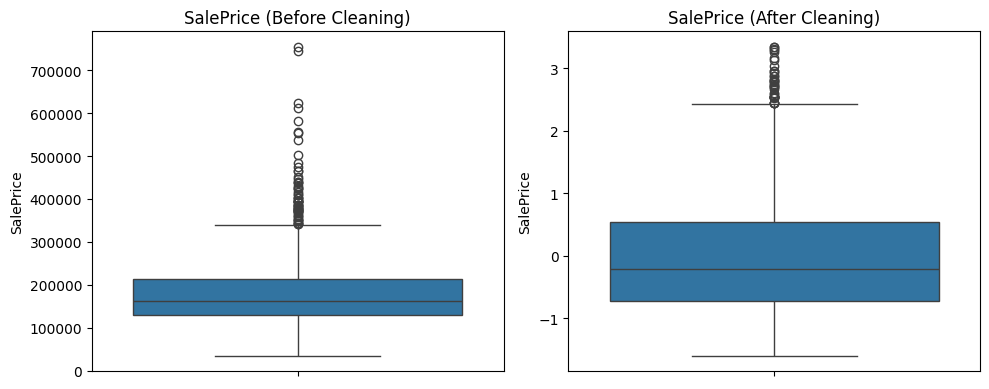

In [25]:
# Select numerical features in the original data
numerical_features = df.select_dtypes(include=['number']).columns

for feature in numerical_features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Boxplot for before cleaning
    sns.boxplot(y=df[feature], ax=axes[0])
    axes[0].set_title(f"{feature} (Before Cleaning)")

    # Boxplot for after cleaning (if the feature exists in df_cleaned)
    if feature in df_cleaned.columns:
        sns.boxplot(y=df_cleaned[feature], ax=axes[1])
        axes[1].set_title(f"{feature} (After Cleaning)")

    plt.tight_layout()
    plt.show()

**Features like 'LotArea' and 'MasVnrArea' had skewed distributions. After transformations, they are more balanced, making them better for modeling.**

___

**Check data types**

df.dtypes is used after visualizing data to confirm each column's data type after cleaning, ensuring all transformations were correctly applied before further analysis.

In [23]:
df_cleaned.dtypes

1stFlrSF         float64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure    category
BsmtFinSF1       float64
BsmtFinType1    category
BsmtUnfSF        float64
GarageArea       float64
GarageFinish    category
GarageYrBlt      float64
GrLivArea        float64
KitchenQual     category
LotArea          float64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF      float64
OverallCond      float64
OverallQual      float64
TotalBsmtSF      float64
YearBuilt        float64
YearRemodAdd     float64
SalePrice        float64
dtype: object

___

## Push files to repo

In [26]:
df_cleaned.to_csv("outputs/datasets/collection/HousePricesCleaned.csv", index=False)
print("Exported the transformed dataset successfully!")

Exported the transformed dataset successfully!


### Data Cleaning Summary
* Missing Values: Filled missing numbers with the median and missing categories with the most common value. Removed columns with too many missing values.
* Skewness Transformation: Used log and Box-Cox to make data more normal.
* Standardization: Scaled all numbers to be on the same scale with StandardScaler.
* Type Conversion: Changed text columns to categories to save memory.
* Visualization: Used boxplots and histograms to check data after cleaning.
* Export: Saved the cleaned data for further analysis.